#**Importing libraries**

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import arviz as az 
import pymc3 as pm 
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import linear_model


#**Importing data**

In [5]:
socio = pd.read_csv("socioambiental_mun.csv", sep=';', encoding="latin1", low_memory=False,)

dengue = pd.read_csv("prevalencia_2007_2017_mun.csv", sep=';', low_memory=False,)

pop = pd.read_excel("estimativa_municipios_TCU_2015.ods",
                             sheet_name="Municípios", header=1).dropna()[["COD. UF", "NOME DO MUNICÍPIO", "POPULAÇÃO ESTIMADA"]]
pop = pop.loc[pop['COD. UF'] == 27.0]

# setting float values
socio['lixo']    = socio['lixo'].apply(lambda x: float(str(x).replace(',', '.')))
socio['esgoto']  = socio['esgoto'].apply(lambda x: float(str(x).replace(',', '.')))
socio['estudo']  = socio['estudo'].apply(lambda x: float(str(x).replace(',', '.')))
socio['salario'] = socio['salario'].apply(lambda x: float(str(x).replace(',', '.')))

# solving na values
socio.drop(socio.index[-1], axis=0, inplace=True)
socio.fillna(socio['estudo'].mean(), inplace=True)

# **Merging the datas**

Now we have data about socio-environmental, estimated population and number of dengue cases of which municipiality, it's necessery to merge these informations and create an incidence rate.

## Merging socio-environmental and estimated population

In [6]:
mergepop = pd.merge(pop, socio, left_on="NOME DO MUNICÍPIO", right_on="municipio").drop(
    ["COD. UF", "NOME DO MUNICÍPIO"], axis=1).rename({
        "POPULAÇÃO ESTIMADA": "pop estimada"
    }, axis=1)
mergepop

,pop estimada,municipio,lixo,esgoto,estudo,salario
0,20434,Água Branca,63.68,70.12,77.04000,93.75
1,17847,Anadia,18.35,80.93,73.81000,89.70
2,231053,Arapiraca,8.73,80.79,58.06000,91.51
3,47298,Atalaia,23.25,75.71,72.34000,90.14
4,15742,Barra de Santo Antônio,11.97,76.38,66.47000,89.95
...,...,...,...,...,...,...
97,19980,Taquarana,56.00,90.59,73.66000,94.52
98,44169,Teotônio Vilela,8.77,52.51,81.61000,91.57
99,27798,Traipu,71.45,89.71,69.95000,84.55
100,66017,União dos Palmares,20.43,34.71,70.53000,91.15


## Merging and creating the incidence rate

In [7]:
merge_prev = pd.merge(mergepop, dengue, on='municipio', how='left')
merge_prev['total '].fillna(0, inplace=True)
merge_prev["incidence rate"] = merge_prev['total '] / merge_prev['pop estimada']
merge_prev['incidence rate'] = merge_prev['incidence rate'].astype(float)
merge_prev['incidence rate'] = round(merge_prev['incidence rate'], 3)
merge_prev.sort_values('incidence rate', ascending=False)

,pop estimada,municipio,lixo,esgoto,estudo,salario,cod,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez,total,incidence rate
2,231053,Arapiraca,8.73,80.79,58.06,91.51,270030,2119,2097,4674,5675,3808,3857,2426,1824,1500,1517,2500,2451,34448,0.149
53,25590,Mata Grande,67.59,78.21,69.99,86.84,270500,632,353,491,527,318,91,34,31,96,107,259,422,3361,0.131
66,73878,Palmeira dos Índios,30.85,86.25,69.75,89.85,270630,425,497,1479,1905,1663,1030,460,390,329,511,719,121,9529,0.129
35,18621,Inhapi,53.25,86.21,86.24,86.73,270330,88,189,161,84,53,14,20,46,437,398,375,133,1998,0.107
49,32171,Maragogi,47.53,86.40,59.42,90.73,270450,28,108,440,761,907,421,359,103,47,38,37,20,3269,0.102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,8151,Porto de Pedras,54.11,95.37,74.59,92.55,270740,1,0,7,4,10,6,3,3,1,2,1,1,39,0.005
48,3622,Mar Vermelho,34.60,61.76,81.45,88.87,270490,1,0,2,3,2,1,3,3,0,1,0,0,16,0.004
42,4269,Jundiá,34.25,95.82,73.38,93.55,270390,3,0,0,0,2,3,5,0,0,0,1,3,17,0.004
23,56631,Coruripe,12.19,83.33,65.58,90.53,270230,14,23,28,30,29,25,43,19,14,6,4,2,237,0.004


#**Clustering the variables and creating a socio-environmental deficiency index**

Before building a predictive model, we create a socio-environmental deficiency index through principal component analysis (PCA). 

Subset including variables to be clustered

In [8]:
subset = merge_prev[["lixo", "esgoto",	"estudo",	"salario"]]

Principal component analysis

In [9]:
pca = PCA()
pca.fit(subset).explained_variance_ratio_

array([0.66027351, 0.24217146, 0.08827609, 0.00927894])

In [10]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(subset)

cluster_map = pd.DataFrame()
cluster_map['data_index'] = subset.index.values
cluster_map['cluster'] = kmeans.labels_

cluster_map['cluster'].value_counts()
subset.loc[cluster_map['cluster'] == 2].describe()

merge_prev['cluster'] = kmeans.labels_

Cluster x incidence rate plot

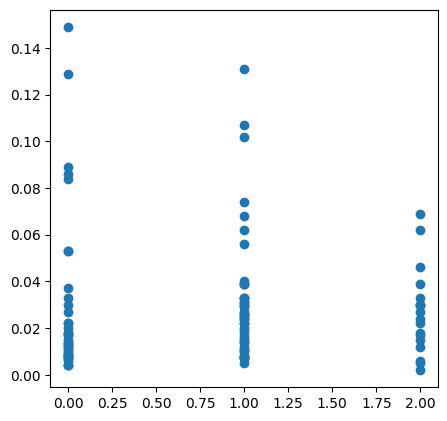

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
plt.scatter(merge_prev['cluster'], merge_prev['incidence rate'])

Analysing the avarage and variance of varible values, we can index which cluster and define it's socio-environmental deficiency.

In [11]:
merge_prev[merge_prev['cluster'] == 0][["lixo", "esgoto",	"estudo",	"salario"]].describe()

,lixo,esgoto,estudo,salario
count,38.000000,38.000000,38.000000,38.000000
mean,21.476053,83.370000,71.488869,91.201579
std,10.409066,10.707862,8.837346,3.261645
min,3.290000,61.760000,47.770000,78.860000
25%,12.462500,75.877500,66.565000,89.997500
50%,20.255000,84.920000,73.245000,91.650000
75%,32.050000,92.892500,79.210000,93.285000
max,38.620000,98.500000,84.270000,95.940000


In [12]:
merge_prev[merge_prev['cluster'] == 1][["lixo", "esgoto",	"estudo",	"salario"]].describe()

,lixo,esgoto,estudo,salario
count,46.000000,46.000000,46.000000,46.00000
mean,52.658696,90.714565,74.840217,91.90500
std,10.844450,9.923797,10.390956,2.86476
min,34.480000,61.350000,32.370000,84.55000
25%,43.267500,87.337500,70.425000,90.49750
50%,52.095000,93.770000,77.865000,92.35000
75%,58.855000,97.930000,81.257500,94.01500
max,75.820000,99.760000,86.240000,96.60000


In [13]:
merge_prev[merge_prev['cluster'] == 2][["lixo", "esgoto",	"estudo",	"salario"]].describe()

,lixo,esgoto,estudo,salario
count,18.000000,18.000000,18.000000,18.000000
mean,16.162222,39.553333,73.737222,90.943333
std,10.191281,9.227490,7.713682,2.798113
min,2.350000,26.080000,60.640000,83.940000
25%,7.982500,32.125000,70.750000,90.075000
50%,16.640000,38.750000,73.380000,91.360000
75%,21.032500,45.452500,80.657500,92.810000
max,36.950000,57.880000,85.130000,95.400000


In [14]:
merge_prev[["lixo", "esgoto",	"estudo",	"salario"]].describe()

,lixo,esgoto,estudo,salario
count,102.000000,102.000000,102.000000,102.000000
mean,34.601078,78.949902,73.397030,91.473235
std,19.582823,21.147360,9.437736,3.005705
min,2.350000,26.080000,32.370000,78.860000
25%,18.147500,68.372500,69.800000,90.187500
50%,35.100000,86.750000,74.330000,91.790000
75%,49.207500,94.630000,80.470000,93.540000
max,75.820000,99.760000,86.240000,96.600000


Mapping the clusters

In [15]:
mapping = {
    0: 1, 
    1: 2, 
    2: 0, 
}
merge_prev['cluster'] = merge_prev['cluster'].apply(lambda x: mapping[x])

Groups of risk

In [16]:
low_risk = merge_prev[merge_prev['cluster'] == 0]
medium_risk = merge_prev[merge_prev['cluster'] == 1]
high_risk = merge_prev[merge_prev['cluster'] == 2]

Histograms of the incidences of risk groups

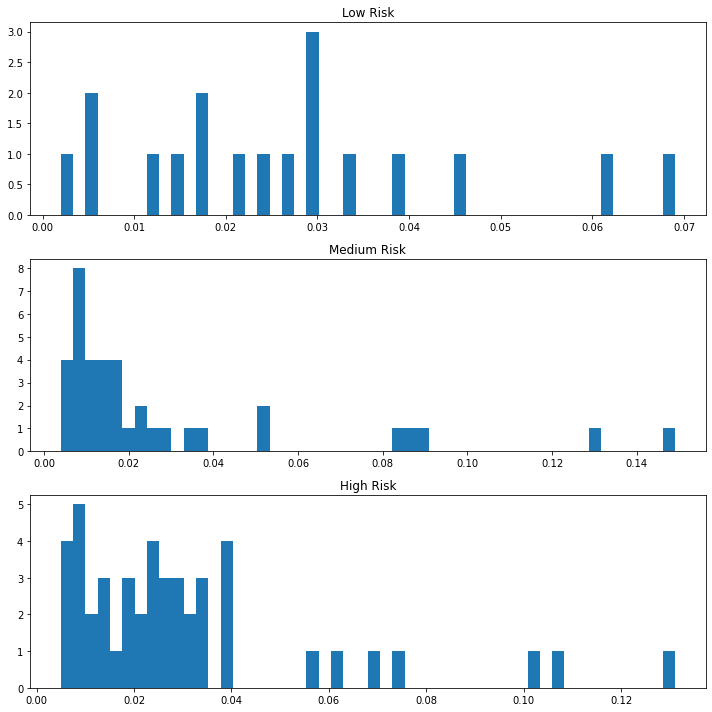

In [17]:
fig,axes = plt.subplots(3,1,figsize=(10,10))

axes[0].hist(low_risk['incidence rate'], bins=50)
axes[0].set_title("Low Risk")

axes[1].hist(medium_risk['incidence rate'], bins=50)
axes[1].set_title("Medium Risk")

axes[2].hist(high_risk['incidence rate'], bins=50)
axes[2].set_title("High Risk")

plt.tight_layout();

#**Bayesian modeling**

##Student T Likelihood

MCMC diagnostics:

*   From the following trace plot, we can visually get the plausible values of 𝜇 from the posterior.
*   We should compare this result with those from the the result we obtained analytically.




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  import sys
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν, σ, μ]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8791938566319271, but should be close to 0.8. Try to increase the number of tuning steps.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


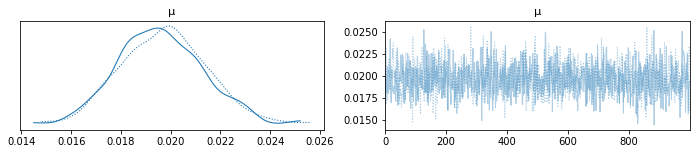

In [20]:
with pm.Model() as model_t:
  
  μ = pm.Uniform('μ', lower=0, upper=0.15)
  σ = pm.HalfNormal('σ', sd=10)
  ν = pm.Exponential('ν', 1/1)
  y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=merge_prev['incidence rate'])
  trace_t = pm.sample(2000, tune=2000)

az.plot_trace(trace_t[:1000], var_names = ['μ']);

In [24]:
merge_prev['incidence rate'].mean()

0.029509803921568604



*   The left plot shows the distribution of values collected for 𝜇. What we get is a measure of uncertainty and credible values of 𝜇 between 0.016 and 0.024.
*   It is obvious that samples that have been drawn from distributions that are significantly different from the target distribution.



## Poisson Distribution

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  import sys
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [μ]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


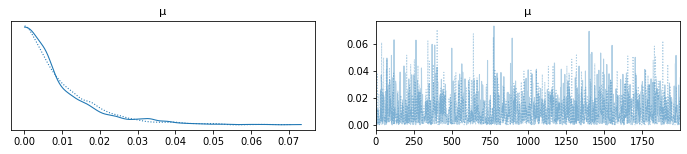

In [25]:
with pm.Model() as model_p:
  
  μ = pm.Uniform('μ', lower=0, upper=0.15)
  
  ## Define Poisson likelihood
  y = pm.Poisson('y', mu=μ, observed=merge_prev['incidence rate'].values)
  trace_p = pm.sample(2000, tune=2000)

az.plot_trace(trace_p);

The measure of uncertainty and credible values of 𝜇 is between 0.00 and 0.07. Not suitable for our data.

##Inverse Gaussian Distribution

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.7078204911807153, but should be close to 0.8. Try to increase the number of tuning steps.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f042d0a6c50>,
      dtype=object)

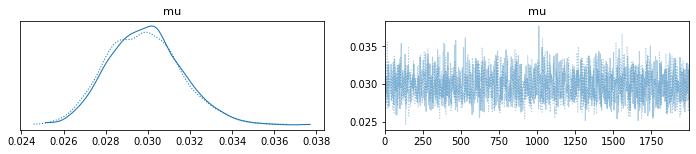

In [26]:
with pm.Model() as model_w:
    
    #prior_sig = pm.Exponential("prior_sig", lam=0.9) 
    μ = pm.Uniform("mu", lower=0, upper=0.15)
    
    like = pm.Wald(
        "likelihood", 
        mu=μ,
        lam=0.09, #0.07 ou 0.09
        observed=merge_prev['incidence rate'],
    )

with model_w:
  trace_wald = pm.sample(2000, tune=2000)

az.plot_trace(trace_wald, var_names=['mu'])

The measure of uncertainty and credible values of 𝜇 is between 0.024 and 0.036 minutes, and it is very closer to the target sample mean.

###Posterior checks

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


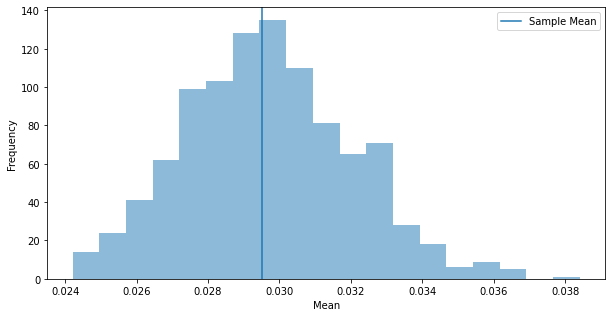

In [27]:
ppc = pm.sample_posterior_predictive(trace_wald, samples=1000, model=model_w)
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([n.mean() for n in ppc['likelihood']], bins=19, alpha=0.5)
ax.axvline(merge_prev['incidence rate'].mean(), label='Sample Mean')
ax.set(xlabel='Mean', ylabel='Frequency')
plt.legend()

These confirm that Inverse Gaussian Distribution is suitable for our data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `autocorrplot` from PyMC3 is just an alias for `plot_autocorr` from ArviZ. Please switch to `pymc3.plot_autocorr` or `arviz.plot_autocorr`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


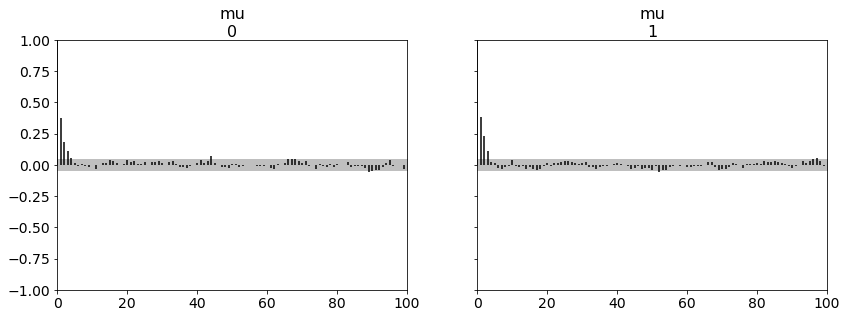

In [ ]:
_ = pm.autocorrplot(trace_wald)

We want the autocorrelation to fall as the x-axis increases in the graph. Because this indicates a low degree of correlation between our samples.

Our Inverse Gaussian model samples dropped to low values of autocorrelation, which is a good sign.

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
posterior predictive variable likelihood's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


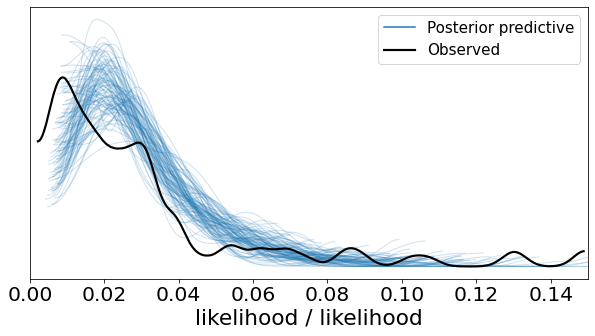

In [ ]:
y_ppc = pm.sample_posterior_predictive(trace_wald, 100, model_w, random_seed=123) 
y_pred = az.from_pymc3(trace=trace_wald, posterior_predictive=y_ppc) 
az.plot_ppc(y_pred, figsize=(10, 5), mean=False) 
plt.xlim(0, 0.15);

Using the Inverse Gaussian distribution in our model leads to predictive samples that seem to better fit the data in terms of the location of the peak of the distribution and also its spread.

The single (black) line is a kernel density estimate (KDE) of the data and the many purple lines are KDEs calculated from each of the 100 subsequent predictive samples. The blue lines reflect the uncertainty we have about the inferred distribution of the predicted data.
From the graph above, we can consider the scale of an Inverse Gaussian distribution as a reasonable practical proxy for the standard deviation of the data.

### Odds ratio

Does socio-envorinmental deficiency index of county affects incidence rate of dengue? To do it we will use the concept of odds, and we can estimate the odds ratio of socio-envorinmental vulnerability like this:

First we do a hierarquical model with Inverse Gaussian Distribution

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu, prior_sig]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f042546a250>,
      dtype=object)

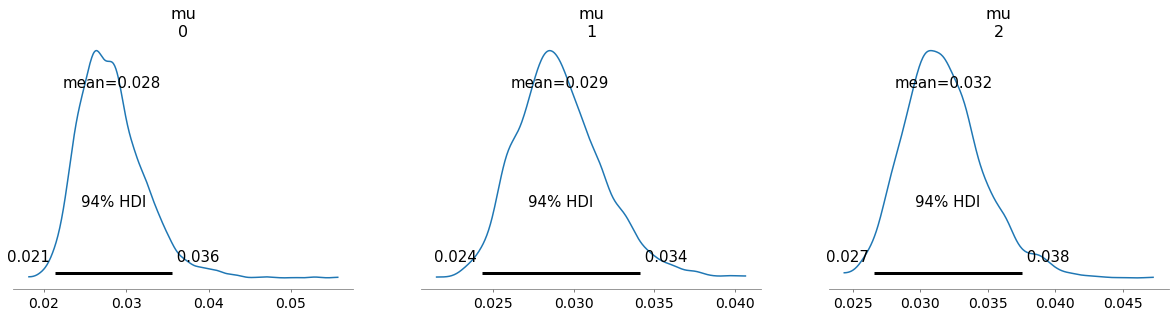

In [32]:
with pm.Model() as wald_model_h:
    
    prior_sig = pm.Exponential("prior_sig", lam=0.9) 
    mu = pm.HalfNormal("mu", sd=prior_sig, shape=(3,))
    
    like = pm.Wald(
        "likelihood", 
        mu=mu[merge_prev['cluster']],
        lam=0.09, #0.07 ou 0.09
        observed=merge_prev['incidence rate'],
    )

with wald_model_h:
  trace_wald_h = pm.sample(2000, tune=2000)

az.plot_posterior(trace_wald_h, var_names=['mu'])

Then we can estimate odds ratio and percentage effect for all the variables.

In [34]:
stat_df = pm.summary(trace_wald_h)
stat_df['odds_ratio'] = np.exp(stat_df['mean'])
stat_df['percentage_effect'] = 100 * (stat_df['odds_ratio'] - 1)
stat_df.sort_values('odds_ratio', ascending=False)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,odds_ratio,percentage_effect
prior_sig,0.058,0.059,0.014,0.134,0.001,0.001,3007.0,2030.0,1.0,1.059715,5.971500
mu[2],0.032,0.003,0.027,0.038,0.000,0.000,3415.0,2434.0,1.0,1.032518,3.251751
mu[1],0.029,0.003,0.024,0.034,0.000,0.000,3597.0,2644.0,1.0,1.029425,2.942459
mu[0],0.028,0.004,0.021,0.036,0.000,0.000,3980.0,2741.0,1.0,1.028396,2.839568


We can interpret percentage_effect along those lines: “ If a county is in a high socio-environmental deficiency index, the odds of having high dengue incidence rate increases by 3,25%.”